In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

## import data

In [2]:
# env_keep = ['FID','size','juld','data_centre_name','position','pres',
#             'pres_qc','temp','temp_qc','psal','psal_qc']
# env = pd.read_csv('environment1.csv',skiprows=26,usecols=env_keep)
phyto_keep = ['FID','LATITUDE','LONGITUDE','SAMPLE_TIME_UTC','FUNCTIONAL_GROUP','BIOVOLUME_UM3_L',
             'TAXON_NAME','FAMILY']
phyto = pd.read_csv('The_Australian_Phytoplankton_Database_(1844_-_ongoing)_-_abundance_and_biovolume.csv',usecols=phyto_keep)
# biomass_keep = ['FID','TIME','biomass_index_mg_m3']
# biomass = pd.read_csv('IMOS_-_AusCPR#_Biomass_Index_(mg_m3).csv',usecols=biomass_keep)

## cleaning

In [5]:
# # environmental data
# # qc columns have 'goodness' of data, we don't want qc above 3
# env = env[(env.loc[:,env.columns.str.contains('qc')] != 4).all(axis=1)]
# # remove all arbitary letters from indentifier strings
# env.loc[:,'FID'] = env.FID.str.slice(60) 
# # transform to datetime
# env.loc[:,'juld'] = pd.to_datetime(env.juld, unit='s', origin='unix') 
# # sort by date
# env = env.sort_values(by='juld').reset_index(drop=True)

In [4]:
# phytoplankton data
# remove arbitrary letters from identifier strings
phyto.loc[:,'FID'] = phyto.FID.str.slice(40)
# transform to datetime
phyto.loc[:,'SAMPLE_TIME_UTC'] = pd.to_datetime(pd.to_datetime(phyto.SAMPLE_TIME_UTC), unit='s', origin='unix').astype(int) / 10**9
# sort by date
phyto = phyto.sort_values(by='SAMPLE_TIME_UTC').reset_index(drop=True)

In [6]:
# # biomass data
# biomass.loc[:,'FID'] = biomass.FID.str.slice(56)
# biomass.loc[:,'TIME'] = pd.to_datetime(biomass.TIME, unit='s', origin='unix') 
# biomass = biomass.sort_values(by='TIME').reset_index(drop=True)
# # get rid of faulty data ie. biomass not negative
# biomass = biomass[biomass.biomass_index_mg_m3 >= 0].reset_index(drop=True)

## eda

In [7]:
# set X and y variables, don't include any NaNs
X = phyto[['LATITUDE','LONGITUDE','SAMPLE_TIME_UTC','BIOVOLUME_UM3_L']][~phyto.BIOVOLUME_UM3_L.isnull()]
y = phyto['FUNCTIONAL_GROUP'][~phyto.FUNCTIONAL_GROUP.isnull()]

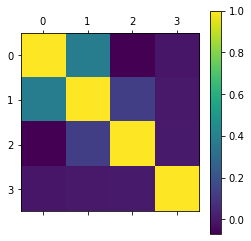

In [8]:
plt.matshow(X.corr())
plt.colorbar()

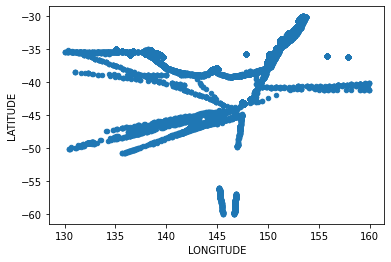

In [9]:
# terribly formatted map of data points
X.plot('LONGITUDE','LATITUDE',kind='scatter')

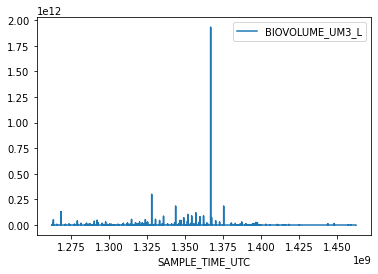

In [10]:
# biomass volume over time
X.plot('SAMPLE_TIME_UTC','BIOVOLUME_UM3_L')
# possible faulty sample

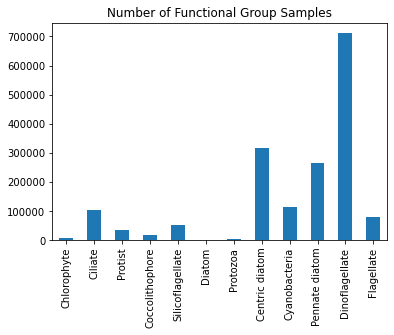

In [11]:
phyto.FUNCTIONAL_GROUP.value_counts(sort=False).plot(kind='bar',title='Number of Functional Group Samples')

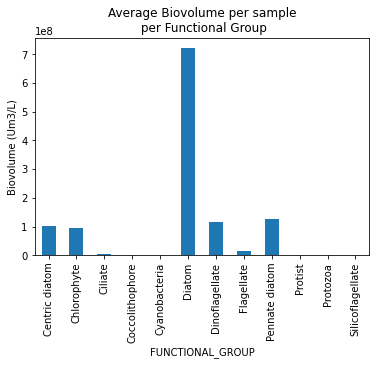

In [12]:
phyto.groupby('FUNCTIONAL_GROUP')['BIOVOLUME_UM3_L'].mean().plot(rot=90,kind='bar',title='Average Biovolume per sample\n per Functional Group',ylabel='Biovolume (Um3/L)')

## Modeling

In [13]:
X = phyto[['LATITUDE','LONGITUDE','SAMPLE_TIME_UTC','BIOVOLUME_UM3_L']][~phyto.BIOVOLUME_UM3_L.isnull()]
y = phyto['FUNCTIONAL_GROUP'][~phyto.FUNCTIONAL_GROUP.isnull()]
kf = KFold(n_splits=5,shuffle=True)
train_acc = []
test_acc = []
for i in np.arange(1,10,2):
    print('doing '+str(i)+' nearest neighbors')
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index],y.iloc[test_index]
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train,y_train)
        train_preds = neigh.predict(X_train)
        test_preds = neigh.predict(X_test)
        train_acc.append(sum(train_preds == y_train)/len(y_train))
        test_acc.append(sum(test_preds == y_test)/len(y_test))

doing 1 nearest neighbors
doing 3 nearest neighbors
doing 5 nearest neighbors
doing 7 nearest neighbors
doing 9 nearest neighbors


In [14]:
train_neigh = [train_acc[x:x+5] for x in range(0,len(train_acc),5)]
test_neigh = [test_acc[x:x+5] for x in range(0,len(test_acc),5)]

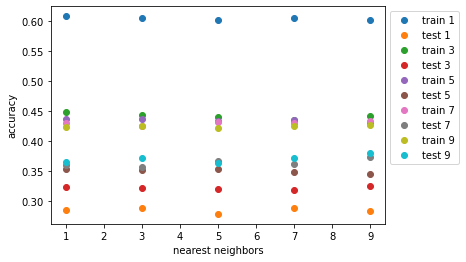

In [15]:
for i in range(len(train_neigh)):
    plt.plot(np.arange(1,10,2),train_neigh[i],linestyle='',marker='o',label='train '+str((i*2)+1))
    plt.plot(np.arange(1,10,2),test_neigh[i],linestyle='',marker='o',label='test '+str((i*2)+1))
plt.xlabel('nearest neighbors')
plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()